In [1]:
import time
import random
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model


Using TensorFlow backend.


In [2]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
#            label = 'Val Error')
#   plt.ylim([0,max(hist['val_mean_absolute_error'].max(), hist['mean_absolute_error'].max())])
  plt.legend()
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
#            label = 'Val Error')
#   plt.ylim([0,max(hist['val_mean_absolute_error'].max(), hist['mean_absolute_error'].max())])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mean_squared_error'],
#            label = 'Val Error')
#   plt.ylim([0,max(hist['val_mean_squared_error'].max(), hist['mean_squared_error'].max())])
  plt.legend()
  plt.show()


In [3]:
# X_COLS = [
#     'weight', 'intra_error', 'frame_avg_wavelet_energy', 
#     'coded_error', 'sr_coded_error', 'tr_coded_error',
#     'pcnt_inter', 'pcnt_motion', 'pcnt_second_ref', 
#     'pcnt_third_ref', 'pcnt_neutral', 'inactive_zone_rows',
#     'inactive_zone_cols', 'MVr', 'mvr_abs', 
#     'MVc', 'mvc_abs', 'MVrv', 
#     'MVcv', 'mv_in_out_count', 'new_mv_count', 
#     'raw_error_stdev',
#     'cq_value',
# ]

X_COLS = [
    'weight',
    'pcnt_inter', 'pcnt_motion', 'pcnt_second_ref', 
    'pcnt_third_ref', 'pcnt_neutral',
    'mv_in_out_count',
    'cq_value',
#     'psnr'
]


X_COLS = X_COLS + [f'nxt_{s}' for s in X_COLS]

Y_COLS = [
    'ms_ssim', 'psnr', 'ssim', 'vmaf'
#     'vmaf'
#     'ms_ssim', 'psnr', 'ssim'
]

# Y_COLS = ['vmaf']

display(f'{len(X_COLS)=}, {len(Y_COLS)=}')

'len(X_COLS)=16, len(Y_COLS)=4'

In [4]:
def load_data():
    csvs = [f for f in glob.glob(f"dataset/csv/*.csv")]
#     csvs = [csvs[3]]  # only 1 cq level
    csvs.sort()
    print(csvs)
    dfs = [pd.read_csv(f) for f in csvs]  # .diff().dropna()
#     for df in dfs:
#         df[X_COLS] = df[X_COLS].shift(-1) - df[X_COLS]
    dfs = [pd.concat([df, df.shift(1).add_prefix('nxt_')], axis=1) for df in dfs]
    return pd.concat(dfs, axis=0, ignore_index=True).dropna()

In [5]:
df = load_data()
display(df)
display(df.describe())

['dataset/csv/s1_30.csv', 'dataset/csv/s1_35.csv', 'dataset/csv/s1_40.csv', 'dataset/csv/s1_45.csv', 'dataset/csv/s1_50.csv', 'dataset/csv/s1_55.csv', 'dataset/csv/s1_60.csv']


,Unnamed: 0,frame,weight,intra_error,frame_avg_wavelet_energy,coded_error,sr_coded_error,tr_coded_error,pcnt_inter,pcnt_motion,...,nxt_motion2,nxt_ms_ssim,nxt_psnr,nxt_ssim,nxt_vif_scale0,nxt_vif_scale1,nxt_vif_scale2,nxt_vif_scale3,nxt_vmaf,nxt_cq_value
1,1,1.0,1.160618,938272.543665,29342160.0,332834.543665,2.052255e+06,756068.543665,0.865931,0.610662,...,0.00000,0.99995,60.19751,0.99984,1.00000,1.00000,1.00000,1.00000,97.42799,30.0
2,2,2.0,1.181501,853136.543665,27864466.0,327928.543665,5.730245e+05,668055.543665,0.761152,0.509804,...,0.27556,0.99674,45.46700,0.99889,0.65612,0.99607,0.99808,0.99894,96.89101,30.0
3,3,3.0,1.202625,767867.543665,26153351.0,256955.543665,4.732775e+05,571896.543665,0.669118,0.423039,...,0.26269,0.99672,46.05847,0.99873,0.67791,0.99701,0.99854,0.99916,97.39241,30.0
4,4,4.0,1.226040,710757.543665,21443737.0,278205.543665,4.158365e+05,482624.543665,0.926838,0.501593,...,0.26269,0.99671,46.08210,0.99873,0.67857,0.99742,0.99876,0.99931,97.21205,30.0
5,5,5.0,1.248711,544988.543665,17787360.0,165585.543665,3.014335e+05,305028.543665,0.731985,0.430392,...,0.26794,0.99672,46.08080,0.99875,0.67749,0.99738,0.99875,0.99931,97.44133,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189191,27023,190.0,1.229014,364817.543665,11475882.0,95449.543665,9.254554e+04,34609.543665,0.465196,0.204167,...,0.00630,0.99938,54.21875,0.99957,0.99717,0.99956,0.99997,1.00000,85.04760,60.0
189192,27024,191.0,1.233539,362240.543665,11441041.0,26095.543665,8.458354e+04,29593.543665,0.998162,0.345221,...,0.01184,0.99948,54.28501,0.99966,0.99803,0.99983,1.00000,1.00000,86.83407,60.0
189193,27025,192.0,1.235129,362000.543665,11412955.0,26015.543665,2.823354e+04,26296.543665,0.996814,0.486152,...,0.00378,0.99951,54.36237,0.99970,0.99884,1.00000,1.00000,1.00000,88.16614,60.0
189194,27026,193.0,1.233220,362200.543665,11491761.0,26125.543665,2.910254e+04,26420.543665,0.997181,0.493382,...,0.00250,0.99953,54.37609,0.99972,0.99922,1.00000,1.00000,1.00000,88.98662,60.0


,Unnamed: 0,frame,weight,intra_error,frame_avg_wavelet_energy,coded_error,sr_coded_error,tr_coded_error,pcnt_inter,pcnt_motion,...,nxt_motion2,nxt_ms_ssim,nxt_psnr,nxt_ssim,nxt_vif_scale0,nxt_vif_scale1,nxt_vif_scale2,nxt_vif_scale3,nxt_vmaf,nxt_cq_value
count,189189.000000,189189.000000,189189.000000,1.891890e+05,1.891890e+05,1.891890e+05,1.891890e+05,1.891890e+05,189189.000000,189189.000000,...,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000
mean,13514.000000,164.042624,1.200821,5.334955e+05,1.694160e+07,6.470673e+04,8.807678e+04,1.399045e+05,0.972476,0.417924,...,1.899240,0.992680,45.292940,0.993688,0.734335,0.933618,0.960154,0.973113,90.276834,45.000000
std,7802.043477,202.996172,0.058471,6.875447e+05,7.887933e+06,1.210712e+05,2.986183e+05,6.883874e+05,0.113905,0.267945,...,2.850154,0.006177,3.849249,0.005999,0.134162,0.055553,0.038480,0.028394,6.904509,10.000026
min,1.000000,0.000000,1.031669,5.148654e+04,0.000000e+00,1.806654e+04,1.806654e+04,1.806654e+04,0.000000,0.000000,...,0.000000,0.898090,29.165670,0.876950,0.148840,0.428780,0.501370,0.569860,20.039230,30.000000
25%,6757.000000,33.000000,1.173908,1.301085e+05,1.271459e+07,3.333654e+04,3.755854e+04,4.126654e+04,0.991789,0.159926,...,0.567750,0.990530,43.203020,0.991910,0.649780,0.910080,0.946750,0.964700,86.979060,35.000000
50%,13514.000000,85.000000,1.190660,2.773245e+05,1.576769e+07,4.071754e+04,4.657954e+04,5.930854e+04,0.998529,0.450123,...,1.015520,0.993880,45.059830,0.995110,0.742440,0.947930,0.971590,0.982030,91.923140,45.000000
75%,20271.000000,209.000000,1.211848,5.789695e+05,1.877815e+07,5.352354e+04,7.111654e+04,1.084425e+05,0.999877,0.632598,...,2.026370,0.996530,46.909150,0.997370,0.828970,0.971380,0.985280,0.990980,95.147570,55.000000
max,27027.000000,1156.000000,1.499939,4.001773e+06,8.457172e+07,3.633678e+06,3.749412e+07,4.882172e+07,1.000000,0.983578,...,69.762050,0.999960,63.222640,0.999950,1.003720,1.023040,1.025310,1.033420,100.000000,60.000000


In [6]:
def build_model():
    model = keras.Sequential([
        layers.Dense(8, activation=tf.nn.selu, input_shape=[len(X_COLS)], kernel_initializer='lecun_normal'),
#         layers.Dense(8, activation=tf.nn.selu, kernel_initializer='lecun_normal'),
        layers.Dense(len(Y_COLS))
    ])
    
    optimizer = tf.keras.optimizers.Nadam(learning_rate=0.003)
    
    # loss: mean_squared_error or mean_absolute_error
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_error'])
    return model


In [7]:
x_train = df[X_COLS]
y_train = df[Y_COLS]
y_train['ssim'] *= 100
y_train['ms_ssim'] *= 100

x_train = (x_train - x_train.mean()) / x_train.std()
y_train = (y_train - y_train.mean()) / y_train.std()

display(x_train)
display(y_train)

<ipython-input-7-1b2b0de17613>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['ssim'] *= 100
<ipython-input-7-1b2b0de17613>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['ms_ssim'] *= 100


,weight,pcnt_inter,pcnt_motion,pcnt_second_ref,pcnt_third_ref,pcnt_neutral,mv_in_out_count,cq_value,nxt_weight,nxt_pcnt_inter,nxt_pcnt_motion,nxt_pcnt_second_ref,nxt_pcnt_third_ref,nxt_pcnt_neutral,nxt_mv_in_out_count,nxt_cq_value
1,-0.687564,-0.935374,0.719320,-1.481882,-0.926456,-0.427653,0.169953,-1.499996,-0.940442,-8.525764,-1.559602,-1.481785,-1.016996,-2.868631,0.064270,-1.499996
2,-0.330423,-1.855254,0.342907,-0.343019,-0.945440,-0.672725,-0.235858,-1.499996,-0.687501,-0.933793,0.719358,-1.481785,-0.926456,-0.427453,0.169955,-1.499996
3,0.030853,-2.663243,0.019091,-0.578125,-0.905281,-0.960289,-0.814224,-1.499996,-0.330363,-1.852436,0.342962,-0.342965,-0.945440,-0.672493,-0.235856,-1.499996
4,0.431316,-0.400659,0.312263,-1.129223,-0.868042,0.425321,-0.752543,-1.499996,0.030908,-2.659338,0.019160,-0.578063,-0.905281,-0.960017,-0.814222,-1.499996
5,0.819041,-2.111315,0.046533,-1.241384,-0.843217,-0.687749,-1.464730,-1.499996,0.431367,-0.399798,0.312320,-1.129139,-0.868042,0.425404,-0.752541,-1.499996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189191,0.482178,-4.453514,-0.797766,-1.134615,2.950727,-0.742488,1.142218,1.499996,0.073046,-0.930569,0.603650,-0.144535,-0.613945,0.553932,0.491483,1.499996
189192,0.559558,0.225505,-0.271337,-1.430115,0.159301,0.301068,-0.145784,1.499996,0.482229,-4.447201,-0.797662,-1.134531,2.950727,-0.742246,1.142220,1.499996
189193,0.586761,0.213670,0.254635,-0.437925,-1.016996,0.821914,0.006842,1.499996,0.559608,0.225525,-0.271255,-1.430020,0.159301,0.301168,-0.145783,1.499996
189194,0.554113,0.216898,0.281620,-0.330078,-1.016996,0.891268,-0.062130,1.499996,0.586811,0.213706,0.254694,-0.437867,-1.016996,0.821943,0.006843,1.499996


,ms_ssim,psnr,ssim,vmaf
1,0.657252,0.045273,0.867091,0.957999
2,0.654015,0.198955,0.840422,1.030620
3,0.652396,0.205094,0.840422,1.004497
4,0.654015,0.204757,0.843756,1.037705
5,0.634589,0.123820,0.837089,0.945736
...,...,...,...,...
189191,1.100811,2.336453,0.995436,-0.498603
189192,1.105668,2.356553,1.002103,-0.305672
189193,1.108905,2.360118,1.005437,-0.186837
189194,1.107286,2.362194,1.005437,-0.188035


In [8]:
dataset = tf.data.Dataset.from_tensor_slices((x_train.values, y_train.values))
train_dataset = dataset.shuffle(len(x_train)).batch(2048)

In [9]:
model = build_model()
display(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
Total params: 172
Trainable params: 172
Non-trainable params: 0
_________________________________________________________________


None

In [10]:
# model.fit(train_dataset, epochs=10)
history = model.fit(train_dataset, epochs=200)  # callbacks=[]

Epoch 1/200
93/93 [==============================] - 0s 3ms/step - loss: 1.1162 - mean_absolute_percentage_error: 1735.9730 - mean_absolute_error: 0.7355 - mean_squared_error: 1.1162
Epoch 2/200
93/93 [==============================] - 0s 3ms/step - loss: 0.7757 - mean_absolute_percentage_error: 1445.1132 - mean_absolute_error: 0.5865 - mean_squared_error: 0.7757
Epoch 3/200
93/93 [==============================] - 0s 3ms/step - loss: 0.7488 - mean_absolute_percentage_error: 1391.8492 - mean_absolute_error: 0.5703 - mean_squared_error: 0.7488
Epoch 4/200
93/93 [==============================] - 0s 3ms/step - loss: 0.7423 - mean_absolute_percentage_error: 1367.2349 - mean_absolute_error: 0.5654 - mean_squared_error: 0.7423
Epoch 5/200
93/93 [==============================] - 0s 3ms/step - loss: 0.7390 - mean_absolute_percentage_error: 1352.4604 - mean_absolute_error: 0.5635 - mean_squared_error: 0.7390
Epoch 6/200
93/93 [==============================] - 0s 3ms/step - loss: 0.7362 - mea

93/93 [==============================] - 0s 3ms/step - loss: 0.7028 - mean_absolute_percentage_error: 1267.4421 - mean_absolute_error: 0.5480 - mean_squared_error: 0.7028
Epoch 46/200
93/93 [==============================] - 0s 3ms/step - loss: 0.7027 - mean_absolute_percentage_error: 1269.7664 - mean_absolute_error: 0.5479 - mean_squared_error: 0.7027
Epoch 47/200
93/93 [==============================] - 0s 3ms/step - loss: 0.7026 - mean_absolute_percentage_error: 1249.7766 - mean_absolute_error: 0.5479 - mean_squared_error: 0.7026
Epoch 48/200
93/93 [==============================] - 0s 3ms/step - loss: 0.7025 - mean_absolute_percentage_error: 1253.4194 - mean_absolute_error: 0.5479 - mean_squared_error: 0.7025
Epoch 49/200
93/93 [==============================] - 0s 3ms/step - loss: 0.7024 - mean_absolute_percentage_error: 1256.2031 - mean_absolute_error: 0.5478 - mean_squared_error: 0.7024
Epoch 50/200
93/93 [==============================] - 0s 3ms/step - loss: 0.7024 - mean_absol

93/93 [==============================] - 0s 3ms/step - loss: 0.7005 - mean_absolute_percentage_error: 1257.5740 - mean_absolute_error: 0.5468 - mean_squared_error: 0.7005
Epoch 90/200
93/93 [==============================] - 0s 3ms/step - loss: 0.7005 - mean_absolute_percentage_error: 1245.5251 - mean_absolute_error: 0.5466 - mean_squared_error: 0.7005
Epoch 91/200
93/93 [==============================] - 0s 3ms/step - loss: 0.7004 - mean_absolute_percentage_error: 1266.9471 - mean_absolute_error: 0.5467 - mean_squared_error: 0.7004
Epoch 92/200
93/93 [==============================] - 0s 3ms/step - loss: 0.7002 - mean_absolute_percentage_error: 1270.7097 - mean_absolute_error: 0.5465 - mean_squared_error: 0.7002
Epoch 93/200
93/93 [==============================] - 0s 3ms/step - loss: 0.7002 - mean_absolute_percentage_error: 1270.8044 - mean_absolute_error: 0.5465 - mean_squared_error: 0.7002
Epoch 94/200
93/93 [==============================] - 0s 3ms/step - loss: 0.7002 - mean_absol

93/93 [==============================] - 0s 3ms/step - loss: 0.6996 - mean_absolute_percentage_error: 1274.3069 - mean_absolute_error: 0.5466 - mean_squared_error: 0.6996
Epoch 134/200
93/93 [==============================] - 0s 3ms/step - loss: 0.6995 - mean_absolute_percentage_error: 1259.1118 - mean_absolute_error: 0.5466 - mean_squared_error: 0.6995
Epoch 135/200
93/93 [==============================] - 0s 3ms/step - loss: 0.6995 - mean_absolute_percentage_error: 1261.7871 - mean_absolute_error: 0.5465 - mean_squared_error: 0.6995
Epoch 136/200
93/93 [==============================] - 0s 3ms/step - loss: 0.6995 - mean_absolute_percentage_error: 1267.4584 - mean_absolute_error: 0.5466 - mean_squared_error: 0.6995
Epoch 137/200
93/93 [==============================] - 0s 3ms/step - loss: 0.6995 - mean_absolute_percentage_error: 1283.3063 - mean_absolute_error: 0.5465 - mean_squared_error: 0.6995
Epoch 138/200
93/93 [==============================] - 0s 3ms/step - loss: 0.6995 - mean_

93/93 [==============================] - 0s 3ms/step - loss: 0.6994 - mean_absolute_percentage_error: 1281.4281 - mean_absolute_error: 0.5465 - mean_squared_error: 0.6994
Epoch 178/200
93/93 [==============================] - 0s 3ms/step - loss: 0.6993 - mean_absolute_percentage_error: 1254.7938 - mean_absolute_error: 0.5466 - mean_squared_error: 0.6993
Epoch 179/200
93/93 [==============================] - 0s 3ms/step - loss: 0.6992 - mean_absolute_percentage_error: 1273.7245 - mean_absolute_error: 0.5466 - mean_squared_error: 0.6992
Epoch 180/200
93/93 [==============================] - 0s 3ms/step - loss: 0.6994 - mean_absolute_percentage_error: 1266.2728 - mean_absolute_error: 0.5465 - mean_squared_error: 0.6994
Epoch 181/200
93/93 [==============================] - 0s 3ms/step - loss: 0.6993 - mean_absolute_percentage_error: 1278.1127 - mean_absolute_error: 0.5466 - mean_squared_error: 0.6993
Epoch 182/200
93/93 [==============================] - 0s 3ms/step - loss: 0.6992 - mean_

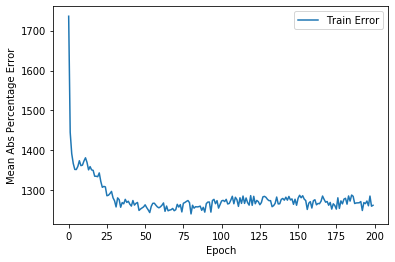

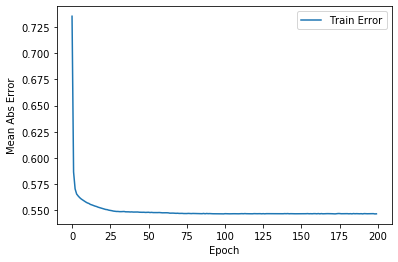

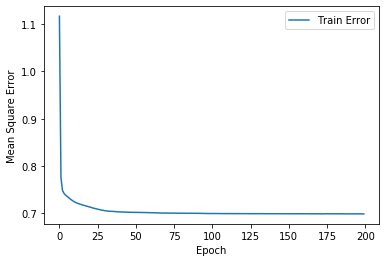

In [11]:
plot_history(history)

In [12]:
def testp(start, end):
    
    tx = df.loc[start:end, X_COLS]
    txf = x_train.loc[start:end, X_COLS]
    ty = df.loc[start:end, Y_COLS]
    tyf = y_train.loc[start:end]
    
    display(tx)
    display(ty)
    display(tyf)
    
    display(model.predict([txf]))

testp(0, 5)
testp(15000, 15000 + 5)
testp(189000, 189000 + 5)

,weight,pcnt_inter,pcnt_motion,pcnt_second_ref,pcnt_third_ref,pcnt_neutral,mv_in_out_count,cq_value,nxt_weight,nxt_pcnt_inter,nxt_pcnt_motion,nxt_pcnt_second_ref,nxt_pcnt_third_ref,nxt_pcnt_neutral,nxt_mv_in_out_count,nxt_cq_value
1,1.160618,0.865931,0.610662,0.000000,0.015196,0.464887,0.017861,30,1.145828,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.0
2,1.181501,0.761152,0.509804,0.129412,0.012010,0.418223,-0.050721,30,1.160618,0.865931,0.610662,0.000000,0.015196,0.464887,0.017861,30.0
3,1.202625,0.669118,0.423039,0.102696,0.018750,0.363468,-0.148465,30,1.181501,0.761152,0.509804,0.129412,0.012010,0.418223,-0.050721,30.0
4,1.226040,0.926838,0.501593,0.040074,0.025000,0.627302,-0.138041,30,1.202625,0.669118,0.423039,0.102696,0.018750,0.363468,-0.148465,30.0
5,1.248711,0.731985,0.430392,0.027328,0.029167,0.415362,-0.258400,30,1.226040,0.926838,0.501593,0.040074,0.025000,0.627302,-0.138041,30.0


,ms_ssim,psnr,ssim,vmaf
1,0.99674,45.46700,0.99889,96.89101
2,0.99672,46.05847,0.99873,97.39241
3,0.99671,46.08210,0.99873,97.21205
4,0.99672,46.08080,0.99875,97.44133
5,0.99660,45.76930,0.99871,96.80634


,ms_ssim,psnr,ssim,vmaf
1,0.657252,0.045273,0.867091,0.957999
2,0.654015,0.198955,0.840422,1.030620
3,0.652396,0.205094,0.840422,1.004497
4,0.654015,0.204757,0.843756,1.037705
5,0.634589,0.123820,0.837089,0.945736


array([[0.5271536 , 0.5132519 , 0.60939234, 0.79950106],
       [0.523847  , 0.52411646, 0.5620989 , 0.72540784],
       [0.7007235 , 0.6746451 , 0.7244974 , 0.76449215],
       [0.8606106 , 0.7738643 , 0.8639174 , 0.95816827],
       [0.7588874 , 0.7207295 , 0.7600195 , 0.9538069 ]], dtype=float32)

,weight,pcnt_inter,pcnt_motion,pcnt_second_ref,pcnt_third_ref,pcnt_neutral,mv_in_out_count,cq_value,nxt_weight,nxt_pcnt_inter,nxt_pcnt_motion,nxt_pcnt_second_ref,nxt_pcnt_third_ref,nxt_pcnt_neutral,nxt_mv_in_out_count,nxt_cq_value
15000,1.374907,1.0,0.010417,0.005270,0.000735,0.668505,-0.076471,30,1.374114,1.0,0.011765,0.005515,0.000245,0.669485,-0.067708,30.0
15001,1.374610,1.0,0.011152,0.004167,0.000245,0.668260,-0.126374,30,1.374907,1.0,0.010417,0.005270,0.000735,0.668505,-0.076471,30.0
15002,1.374797,1.0,0.019240,0.008088,0.001225,0.668382,-0.127389,30,1.374610,1.0,0.011152,0.004167,0.000245,0.668260,-0.126374,30.0
15003,1.374241,1.0,0.016054,0.005147,0.000735,0.668627,-0.080153,30,1.374797,1.0,0.019240,0.008088,0.001225,0.668382,-0.127389,30.0
15004,1.374755,1.0,0.012255,0.005392,0.000245,0.668505,0.015000,30,1.374241,1.0,0.016054,0.005147,0.000735,0.668627,-0.080153,30.0
15005,1.374249,1.0,0.014338,0.004289,0.000123,0.669363,0.042735,30,1.374755,1.0,0.012255,0.005392,0.000245,0.668505,0.015000,30.0


,ms_ssim,psnr,ssim,vmaf
15000,0.99219,45.01375,0.99478,94.69772
15001,0.99231,45.17425,0.99478,94.77959
15002,0.99171,44.62067,0.99453,93.94934
15003,0.99252,45.36267,0.99487,94.53066
15004,0.99246,45.24533,0.99479,94.23465
15005,0.99242,45.32226,0.99471,94.43023


,ms_ssim,psnr,ssim,vmaf
15000,-0.079314,-0.072495,0.182032,0.640333
15001,-0.059888,-0.030792,0.182032,0.652191
15002,-0.157018,-0.174628,0.140362,0.531941
15003,-0.025893,0.018165,0.197033,0.616137
15004,-0.035606,-0.012323,0.183699,0.573264
15005,-0.042081,0.007665,0.170364,0.601591


array([[0.4540975 , 0.5320841 , 0.47261685, 0.75882936],
       [0.46189368, 0.5375681 , 0.47918218, 0.76135576],
       [0.47642016, 0.54613304, 0.49318546, 0.77529585],
       [0.47390258, 0.54598045, 0.49185055, 0.7807609 ],
       [0.44816136, 0.52844274, 0.46912974, 0.76550484],
       [0.4178903 , 0.51024437, 0.44034415, 0.7374512 ]], dtype=float32)

,weight,pcnt_inter,pcnt_motion,pcnt_second_ref,pcnt_third_ref,pcnt_neutral,mv_in_out_count,cq_value,nxt_weight,nxt_pcnt_inter,nxt_pcnt_motion,nxt_pcnt_second_ref,nxt_pcnt_third_ref,nxt_pcnt_neutral,nxt_mv_in_out_count,nxt_cq_value
189000,1.115962,0.982108,0.909681,0.203309,0.000000,0.335366,0.095177,60,1.115240,0.983211,0.906985,0.225245,0.000000,0.353629,0.088974,60.0
189001,1.190867,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60,1.115962,0.982108,0.909681,0.203309,0.000000,0.335366,0.095177,60.0
189002,1.192024,0.999877,0.023897,0.000000,0.203186,0.322020,-0.105128,60,1.190867,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.0
189003,1.191925,0.999877,0.025000,0.043995,0.087010,0.310049,-0.151961,60,1.192024,0.999877,0.023897,0.000000,0.203186,0.322020,-0.105128,60.0
189004,1.192095,1.000000,0.033578,0.072426,0.076103,0.317214,-0.058394,60,1.191925,0.999877,0.025000,0.043995,0.087010,0.310049,-0.151961,60.0
189005,1.191898,0.999877,0.027574,0.060417,0.098897,0.311153,-0.184444,60,1.192095,1.000000,0.033578,0.072426,0.076103,0.317214,-0.058394,60.0


,ms_ssim,psnr,ssim,vmaf
189000,0.99890,46.69938,0.99920,92.27116
189001,0.99887,46.60235,0.99917,92.10697
189002,0.99886,46.59861,0.99917,92.10092
189003,0.99886,46.59817,0.99917,92.10144
189004,0.99886,46.59203,0.99917,92.09795
189005,0.99886,46.59085,0.99917,92.09786


,ms_ssim,psnr,ssim,vmaf
189000,1.006919,0.365482,0.918762,0.288881
189001,1.002063,0.340271,0.913762,0.265100
189002,1.000444,0.339299,0.913762,0.264224
189003,1.000444,0.339185,0.913762,0.264299
189004,1.000444,0.337589,0.913762,0.263794
189005,1.000444,0.337283,0.913762,0.263781


array([[-1.0511669 , -0.87564   , -1.1149983 , -1.3377506 ],
       [-0.84146667, -0.79319274, -0.88117176, -1.219813  ],
       [-0.3122412 , -0.56222737, -0.3821364 , -0.6946317 ],
       [-0.9195181 , -0.8741807 , -1.014729  , -1.2042122 ],
       [-0.8378402 , -0.85504794, -0.93274957, -1.1387566 ],
       [-0.90534866, -0.8492981 , -0.991309  , -1.2057443 ]],
      dtype=float32)